In [1315]:
import sys
print(sys.executable)
# 0) 套件
import os, sys, json, math, time, random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

import os, json, math, pandas as pd, numpy as np, warnings
warnings.filterwarnings("ignore")

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_squared_error, r2_score

import re
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
import torch

if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3  # 轉成 GB
    print(f"GPU 名稱：{device_name}")
    print(f"VRAM 容量：約 {total_memory:.2f} GB")
else:
    print("⚠️ 目前沒有啟用 GPU（使用 CPU）")
    
print('Python:', sys.version)
print('PyTorch:', torch.__version__) # Python 跟 PyTorch 確認

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device name:", torch.cuda.get_device_name(0))#gpu 確認


# 1) 載入資料
DATA_PATH = r"dataset.csv"  # dataset路徑
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)



c:\Users\jerry\.conda\envs\RJ_text_1\python.exe
GPU 名稱：NVIDIA GeForce RTX 4060 Laptop GPU
VRAM 容量：約 8.00 GB
Python: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
PyTorch: 2.5.1
CUDA available: True
GPU device name: NVIDIA GeForce RTX 4060 Laptop GPU
(4424, 35)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


In [1316]:
# 2) 目標與特徵處理

TARGET_COL = 'Target'  # 已由探勘自動找到
assert TARGET_COL in df.columns, f"找不到目標欄位 {TARGET_COL}!"

y = df[TARGET_COL].astype('category')
X = df.drop(columns=[TARGET_COL])

# 假設 y 是你的目標欄位（已經是 Series）
# y = df['Target']




# 自動推斷數值/類別欄位
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

print('數值欄位數:', len(num_cols))
print('類別欄位數:', len(cat_cols))

from sklearn.impute import SimpleImputer

#處理數值特徵（NaN）的資料，用中位數填(沒了)
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())#正規畫
])
#處理類別（字串）特徵
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),#缺值，眾數補上
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))#類別文字數值形式
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# 目標編碼：把類別轉成 0..K-1
class_names = list(y.cat.categories)
y_codes = y.cat.codes.values
num_classes = len(class_names)
print('Target名稱:', class_names)

TARGET_COL = 'Target'
class_counts = pd.read_csv('dataset.csv', usecols=[TARGET_COL])[TARGET_COL].value_counts()
print("\n各類別筆數：")
print(class_counts)
print("\n各類別比例：")
print((class_counts / class_counts.sum()).round(4))

數值欄位數: 34
類別欄位數: 0
Target名稱: ['Dropout', 'Enrolled', 'Graduate']

各類別筆數：
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

各類別比例：
Target
Graduate    0.4993
Dropout     0.3212
Enrolled    0.1795
Name: count, dtype: float64


In [1317]:
# 計算整體熵
p = y.value_counts(normalize=True)

entropy = -(p * np.log2(p)).sum()

print("整體熵 =", round(entropy, 4))

def entropy(series):
    """計算單一變數的熵"""
    p = series.value_counts(normalize=True)
    return -(p * np.log2(p)).sum()

def info_gain(df, feature, target):
    """計算指定特徵的資訊增益"""
    H_total = entropy(df[target])
    weighted_H = 0
    for value, subset in df.groupby(feature):
        weighted_H += len(subset) / len(df) * entropy(subset[target])
    IG = H_total - weighted_H
    return IG

# ig_gender = info_gain(df, 'Gender', 'Target')
# print(f"Gender 的資訊增益: {ig_gender:.4f}")

features = [c for c in df.columns if c != 'Target']
ig_scores = {f: info_gain(df, f, 'Target') for f in features}

sorted_ig = sorted(ig_scores.items(), key=lambda x: x[1], reverse=True)
print("各特徵的資訊增益（由高到低）：")
for f, ig in sorted_ig:
    print(f"{f:<20} {ig:.4f}")

整體熵 = 1.4713
各特徵的資訊增益（由高到低）：
Curricular units 2nd sem (grade) 0.5150
Curricular units 2nd sem (approved) 0.4560
Curricular units 1st sem (grade) 0.4539
Curricular units 1st sem (approved) 0.3563
Curricular units 2nd sem (evaluations) 0.1391
Tuition fees up to date 0.1325
Curricular units 1st sem (evaluations) 0.1302
Course               0.0959
Age at enrollment    0.0895
Application mode     0.0753
Curricular units 2nd sem (enrolled) 0.0727
Curricular units 1st sem (enrolled) 0.0725
Scholarship holder   0.0709
Mother's occupation  0.0491
Father's occupation  0.0445
Debtor               0.0417
Gender               0.0381
Father's qualification 0.0375
Mother's qualification 0.0358
Previous qualification 0.0355
Application order    0.0114
Curricular units 1st sem (credited) 0.0109
Curricular units 2nd sem (without evaluations) 0.0107
Curricular units 1st sem (without evaluations) 0.0104
Curricular units 2nd sem (credited) 0.0100
Marital status       0.0098
Displaced            0.0094
Unem

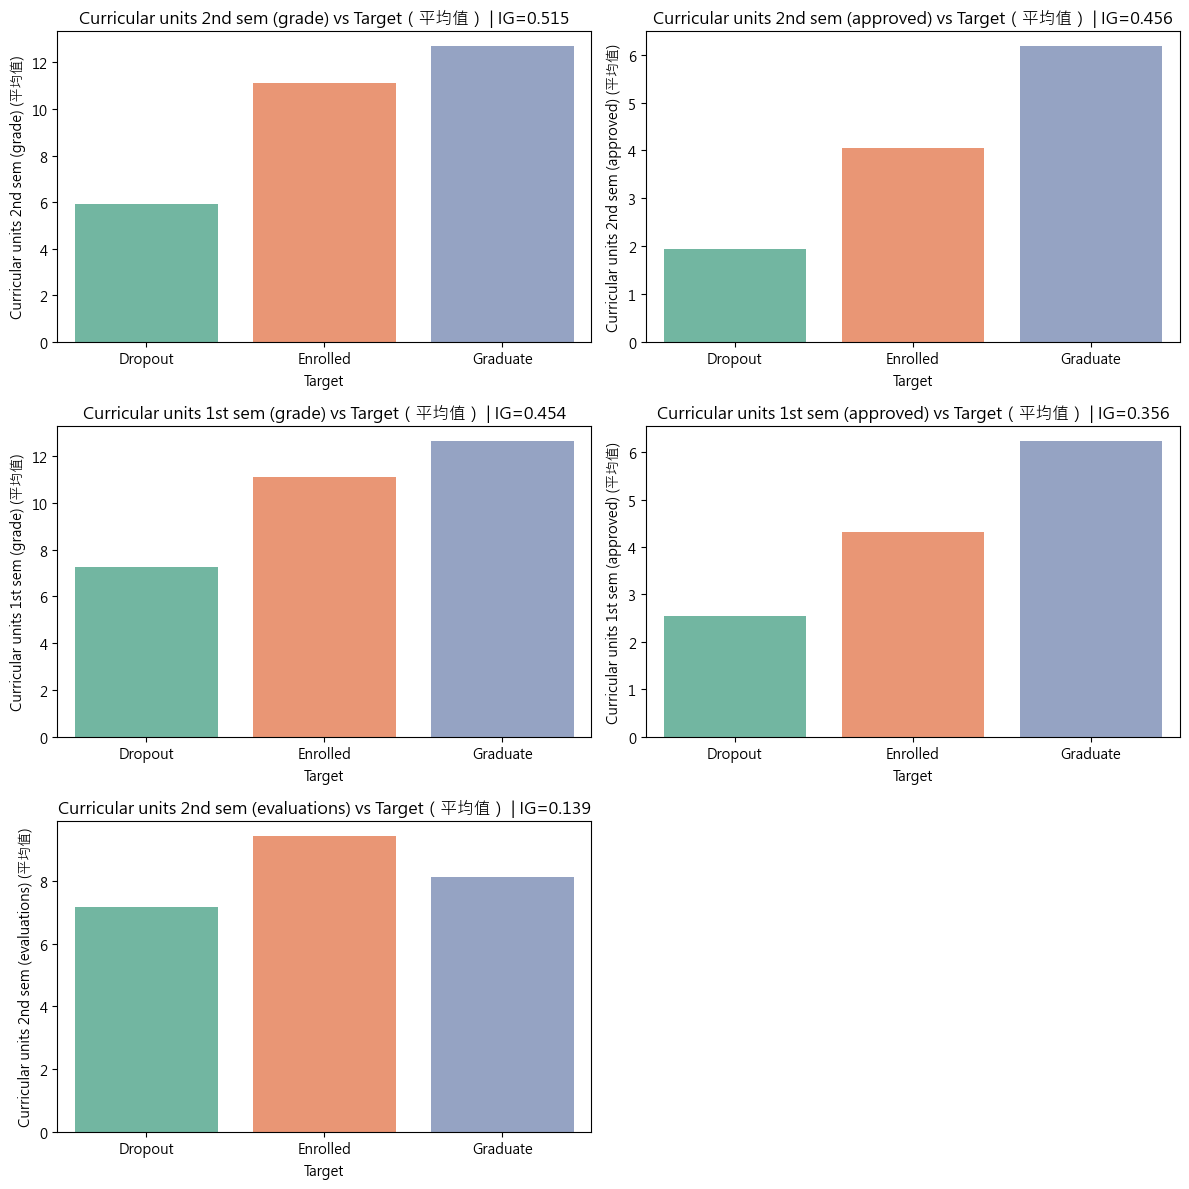

In [1318]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 確保 Target 是分類型
if not pd.api.types.is_categorical_dtype(df["Target"]):
    df["Target"] = df["Target"].astype("category")
target_levels = list(df["Target"].cat.categories)

# 取資訊增益前 5 名
top5 = sorted(ig_scores.items(), key=lambda x: x[1], reverse=True)[:5]
top5_feats = [f for f, _ in top5]

n = len(top5_feats)
ncols = 2
nrows = (n + ncols - 1) // ncols
plt.figure(figsize=(12, 4 * nrows))

for i, col in enumerate(top5_feats, 1):
    plt.subplot(nrows, ncols, i)
    
    if pd.api.types.is_numeric_dtype(df[col]):
        # 數值特徵：以平均值表示不同 Target 的分佈
        mean_df = df.groupby("Target")[col].mean().reset_index()
        sns.barplot(data=mean_df, x="Target", y=col, palette="Set2")
        plt.ylabel(f"{col} (平均值)")
        plt.title(f"{col} vs Target（平均值） | IG={ig_scores[col]:.3f}")
    else:
        # 類別特徵：顯示各類別內 Target 的比例
        prop_df = (
            df.groupby([col, "Target"])
            .size()
            .groupby(level=0)
            .apply(lambda x: x / x.sum())
            .reset_index(name="比例")
        )
        sns.barplot(data=prop_df, x=col, y="比例", hue="Target", palette="Set2")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.05)
        plt.ylabel("比例")
        plt.title(f"{col} vs Target（比例） | IG={ig_scores[col]:.3f}")
        plt.legend(title="Target", loc="best")

plt.tight_layout()
plt.show()


In [1319]:
# 3) 切分資料 
from sklearn.model_selection import train_test_split

# 第一次：切出訓練資料 (70%)，剩下 30% 暫存
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_codes, test_size=0.3, random_state=42, stratify=y_codes
)

# 第二次：把暫存資料分成 驗證(15%) + 測試(15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 儲存每個集合大小
n_train, n_val, n_test = len(X_train), len(X_val), len(X_test)

print(f"訓練集：{n_train} 筆")
print(f"驗證集：{n_val} 筆")
print(f"測試集：{n_test} 筆")



訓練集：3096 筆
驗證集：664 筆
測試集：664 筆


In [1320]:
# 4) 擬合前處理並轉成 numpy
X_train_np = preprocess.fit_transform(X_train)
X_val_np   = preprocess.transform(X_val)
X_test_np  = preprocess.transform(X_test)

input_dim = X_train_np.shape[1]
input_dim

# 5) NumPy 資料打包成 PyTorch Dataset / Dataloader
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = NumpyDataset(X_train_np, y_train)
val_ds   = NumpyDataset(X_val_np, y_val)
test_ds  = NumpyDataset(X_test_np, y_test)

train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=256)
test_dl  = DataLoader(test_ds, batch_size=256)

In [1321]:
# 6) 建立 MLP 模型 有ReLU
class MLP_Relu(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(#是否本身有RELU
            nn.Linear(in_dim, 128),#輸入
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            

            nn.Linear(128, 64),#隱
            nn.Dropout(0.3),
            nn.BatchNorm1d(64),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            

            nn.Linear(64, 32),#隱
            nn.Dropout(0.3),
            nn.BatchNorm1d(32),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            


            nn.Linear(32, num_classes)#輸出
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_Relu = MLP_Relu(input_dim, num_classes).to(device)
model_Relu

# LeakyReLU函式版本
class MLP_LeakyReLU(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            

            nn.Linear(128, 64),
            nn.Dropout(0.3),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.01),

            nn.Linear(64, 32),
            nn.Dropout(0.3),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.01),
            

            nn.Linear(32, num_classes)#nn.CrossEntropyLoss內建softmax
        )
    def forward(self, x):
        return self.net(x)

model_eakyReLU = MLP_LeakyReLU(input_dim, num_classes).to(device)

#5層
class MLP_Relu_5N(nn.Module):
    def __init__(self, in_dim, num_classes,):
        super().__init__()
        self.net = nn.Sequential(#是否本身有RELU
            
            nn.Linear(in_dim, 512),#輸入
            nn.BatchNorm1d(512),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),#隱1
            nn.BatchNorm1d(256),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256,128),#隱2
            nn.BatchNorm1d(128),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128,64),#隱3
            nn.BatchNorm1d(64),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64,32),#隱4
            nn.BatchNorm1d(32),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32,16),#隱5
            nn.BatchNorm1d(16),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),


            nn.Linear(16, num_classes)#輸出
        )
    def forward(self, x):
        return self.net(x)
model_Relu_5N = MLP_Relu_5N(input_dim, num_classes).to(device)
model_Relu_5N

# 7) 類別不平衡處理：class weights
# 依訓練資料的頻率反比計算權重
unique, counts = np.unique(y_train, return_counts=True)#取編號
freq = counts / counts.sum()#取編號次數
class_weights = torch.tensor(1.0 / (freq + 1e-8), dtype=torch.float32).to(device)#類別的比例 (frequency)。
print('class_weights:', class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)#計算每個類別的反比權重-->損失函數

class_weights: tensor([3.1147, 5.5683, 2.0026], device='cuda:0')


In [1322]:
# ==== 1) Dataset & DataLoader ====
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

#train_dl = DataLoader(NumpyDataset(X_train_np, y_train), batch_size=128, shuffle=True)
#val_dl   = DataLoader(NumpyDataset(X_val_np, y_val),   batch_size=256)

# ==== 2) 驗證函式（把 model 與 criterion 當參數傳入）====
def evaluate(model, dataloader, criterion):
    model.eval()
    correct, total, losses = 0, 0, []
    with torch.no_grad():
        for xb, yb in dataloader:#(xb->輸入，yb標籤)
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)#模型預測的原始輸出
            loss = criterion(logits, yb)#計算這批資料的 loss
            losses.append(loss.item())#把 tensor 轉成普通數值->存起來，最後取平均
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return float(np.mean(losses)), correct / total

In [1323]:
# 若你已經有 evaluate()，這行保留
_evaluate = evaluate

def train_with_early_stopping(
    model_fn,
    EPOCHS=2000,
    patience=300,
    min_delta=0.0,              # 早停門檻建議先用 0 或很小值
    lr=1e-3,
    weight_decay=1e-5,          # 比 1e-3 小很多，較不會壓住學習
    monitor="val_loss",         # "val_loss" 或 "val_acc"
    use_scheduler=False,        # ← 預設關閉 LR scheduler
    scheduler_type="plateau",   # "plateau" / "step"（只有 use_scheduler=True 才生效）
    step_size=10,               # StepLR 參數
    gamma=0.5,                  # StepLR 參數
    grad_clip=None              # e.g., 1.0；None 表示不啟用
):
    print(f"[ES cfg] EPOCHS={EPOCHS}, patience={patience}, min_delta={min_delta}, "
          f"lr={lr}, wd={weight_decay}, monitor={monitor}, use_sch={use_scheduler}")

    device_local = device  # 假設你已定義 device
    model = model_fn().to(device_local)

    # 損失：若你有 class_weights 就用，否則為 None
    cw = class_weights.to(device_local) if 'class_weights' in globals() and class_weights is not None else None
    criterion = nn.CrossEntropyLoss(weight=cw)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 可選的學習率排程器（預設關閉）
    scheduler = None
    if use_scheduler:
        if scheduler_type == "plateau":
            mode = 'min' if monitor == "val_loss" else 'max'
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode=mode, factor=0.5, patience=max(patience//4, 3), verbose=True
            )
        elif scheduler_type == "step":
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        else:
            raise ValueError(f"Unknown scheduler_type: {scheduler_type}")

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_score = None
    best_state = None
    best_epoch = -1
    no_improve = 0

    print(f"\n===== 開始訓練（Early Stopping）共 {EPOCHS} epochs | 監控 {monitor}，patience={patience} =====")
    for epoch in range(1, EPOCHS + 1):
        # ---- Train ----
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for xb, yb in train_dl:
            xb, yb = xb.to(device_local), yb.to(device_local)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()

            # 可選：梯度裁剪，幫助穩定
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            optimizer.step()

            total_loss += loss.item()
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_loss = total_loss / max(1, len(train_dl))
        train_acc  = correct / max(1, total)

        # ---- Val ----
        val_loss, val_acc = _evaluate(model, val_dl, criterion)

        # 紀錄
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # 監控分數（越大越好）
        score = (-val_loss) if monitor == "val_loss" else val_acc

        # 學習率調整
        if use_scheduler and scheduler is not None:
            if scheduler_type == "plateau":
                metric = val_loss if monitor == "val_loss" else val_acc
                scheduler.step(metric)  # plateau 需要 metric
            else:
                scheduler.step()        # step 類型不看 metric

        # 是否改善
        improved = (best_score is None) or (score > best_score + min_delta)

        if improved:
            best_score  = score
            # 存 CPU 版權重，避免顯存占用
            best_state  = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch  = epoch
            no_improve  = 0
        else:
            no_improve += 1

        print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f} | no_improve={no_improve}")

        if no_improve >= patience:
            print(f"⏹ 早停：連續 {patience} 個 epoch 無顯著改善（監控 {monitor}）。")
            break

    # 還原最佳權重
    if best_state is not None:
        model.load_state_dict({k: v.to(device_local) for k, v in best_state.items()})
        print(f"✅ 已還原最佳權重（最佳 epoch = {best_epoch}）")
    else:
        print("⚠️ 未記錄到最佳權重，使用最後一輪參數。")

    return model, history, best_epoch


In [1324]:
# 5隱藏 Relu
model_relu_es_5n, hist_relu_es_5n, best_ep_relu_5n = train_with_early_stopping(
    model_fn=lambda: MLP_Relu_5N(input_dim, num_classes),
    #EPOCHS=300,
    #patience=30,
    monitor="val_loss"
)

[ES cfg] EPOCHS=2000, patience=300, min_delta=0.0, lr=0.001, wd=1e-05, monitor=val_loss, use_sch=False

===== 開始訓練（Early Stopping）共 2000 epochs | 監控 val_loss，patience=300 =====
Epoch 001 | train_loss=1.1532 acc=0.2997 | val_loss=1.0958 acc=0.2771 | no_improve=0
Epoch 002 | train_loss=1.0599 acc=0.3679 | val_loss=1.0872 acc=0.3343 | no_improve=0
Epoch 003 | train_loss=1.0319 acc=0.4289 | val_loss=1.0700 acc=0.3539 | no_improve=0
Epoch 004 | train_loss=1.0572 acc=0.4444 | val_loss=1.0410 acc=0.4774 | no_improve=0
Epoch 005 | train_loss=1.0103 acc=0.4748 | val_loss=1.0035 acc=0.6054 | no_improve=0
Epoch 006 | train_loss=0.9734 acc=0.5191 | val_loss=0.9699 acc=0.6506 | no_improve=0
Epoch 007 | train_loss=1.0015 acc=0.5472 | val_loss=0.9422 acc=0.6642 | no_improve=0
Epoch 008 | train_loss=0.9585 acc=0.5727 | val_loss=0.9185 acc=0.6687 | no_improve=0
Epoch 009 | train_loss=0.9566 acc=0.5969 | val_loss=0.9023 acc=0.6822 | no_improve=0
Epoch 010 | train_loss=0.9355 acc=0.6244 | val_loss=0.8876

In [1325]:
# ==== 4) 訓練兩個版本並比較 ====
# EPOCHS = 300
# PATIENCE = 30

# 2 隱藏 ReLU 版本早停版本
model_relu_es, hist_relu_es, best_ep_relu = train_with_early_stopping(
    model_fn=lambda: MLP_Relu(input_dim, num_classes),
    # EPOCHS=300,
    # patience=30,
    monitor="val_loss"
)






[ES cfg] EPOCHS=2000, patience=300, min_delta=0.0, lr=0.001, wd=1e-05, monitor=val_loss, use_sch=False

===== 開始訓練（Early Stopping）共 2000 epochs | 監控 val_loss，patience=300 =====
Epoch 001 | train_loss=1.1335 acc=0.3589 | val_loss=1.0830 acc=0.2364 | no_improve=0
Epoch 002 | train_loss=1.0239 acc=0.4713 | val_loss=1.0630 acc=0.3449 | no_improve=0
Epoch 003 | train_loss=1.0172 acc=0.5165 | val_loss=1.0336 acc=0.4533 | no_improve=0
Epoch 004 | train_loss=0.9767 acc=0.5640 | val_loss=0.9977 acc=0.5542 | no_improve=0
Epoch 005 | train_loss=0.9259 acc=0.5998 | val_loss=0.9658 acc=0.6205 | no_improve=0
Epoch 006 | train_loss=0.9297 acc=0.6286 | val_loss=0.9351 acc=0.6461 | no_improve=0
Epoch 007 | train_loss=0.9296 acc=0.6512 | val_loss=0.9110 acc=0.6702 | no_improve=0
Epoch 008 | train_loss=0.8786 acc=0.6654 | val_loss=0.8916 acc=0.6807 | no_improve=0
Epoch 009 | train_loss=0.8809 acc=0.6579 | val_loss=0.8763 acc=0.6852 | no_improve=0
Epoch 010 | train_loss=0.8476 acc=0.6676 | val_loss=0.8633

In [1326]:
# LeakyReLU 版本早停版本
model_sig_es,  hist_sig_es,  best_ep_sig = train_with_early_stopping(
    model_fn=lambda: MLP_LeakyReLU(input_dim, num_classes),
    # EPOCHS=300,
    # patience=30,
    monitor="val_loss"
)

# ✅ LeakyReLU 維持原本的標準訓練
# model_noact = MLP_LeakyReLU(input_dim, num_classes)
# model_noact, hist_noact = train_model(model_noact, "LeakyReLU 版本", EPOCHS)

# === 繪圖（使用早停 ReLU 與 LeakyReLU） ===
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

[ES cfg] EPOCHS=2000, patience=300, min_delta=0.0, lr=0.001, wd=1e-05, monitor=val_loss, use_sch=False

===== 開始訓練（Early Stopping）共 2000 epochs | 監控 val_loss，patience=300 =====
Epoch 001 | train_loss=1.1086 acc=0.2988 | val_loss=1.0932 acc=0.2937 | no_improve=0
Epoch 002 | train_loss=1.0958 acc=0.3569 | val_loss=1.0756 acc=0.3434 | no_improve=0
Epoch 003 | train_loss=1.0085 acc=0.4180 | val_loss=1.0501 acc=0.3569 | no_improve=0
Epoch 004 | train_loss=0.9893 acc=0.4525 | val_loss=1.0166 acc=0.4142 | no_improve=0
Epoch 005 | train_loss=0.9114 acc=0.5165 | val_loss=0.9816 acc=0.4910 | no_improve=0
Epoch 006 | train_loss=0.9383 acc=0.5526 | val_loss=0.9480 acc=0.5407 | no_improve=0
Epoch 007 | train_loss=0.8963 acc=0.5782 | val_loss=0.9219 acc=0.5919 | no_improve=0
Epoch 008 | train_loss=0.8676 acc=0.6024 | val_loss=0.9013 acc=0.6250 | no_improve=0
Epoch 009 | train_loss=0.8581 acc=0.6363 | val_loss=0.8855 acc=0.6446 | no_improve=0
Epoch 010 | train_loss=0.8114 acc=0.6550 | val_loss=0.8737

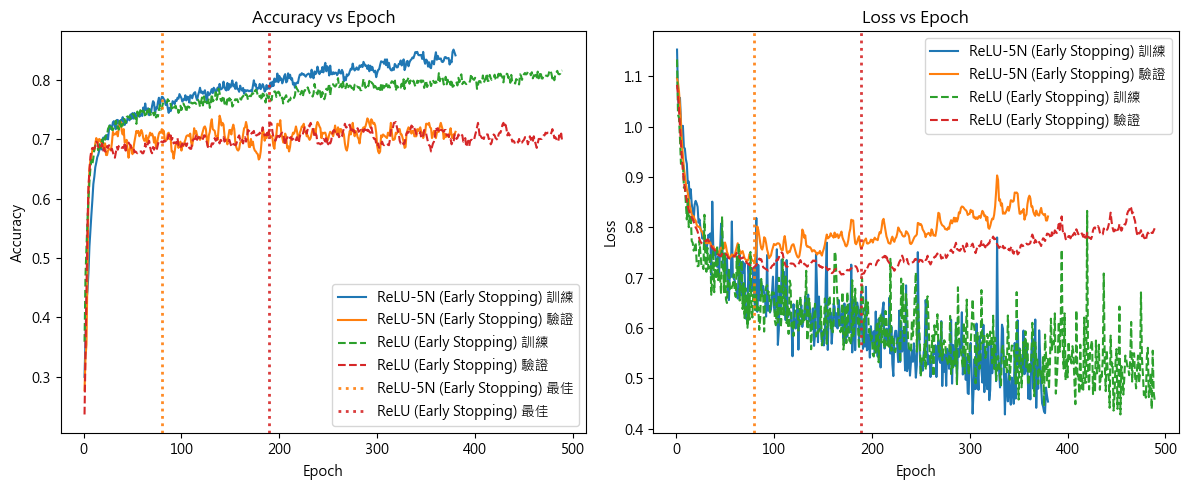

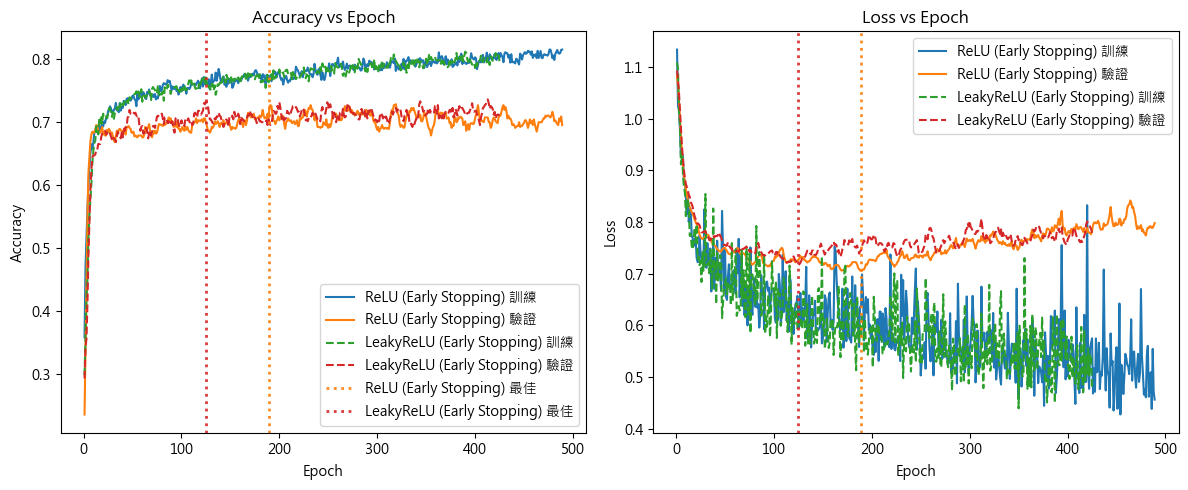


📊 === ReLU-5N (Early Stopping) 模型最終結果 ===
Train Loss: 0.4535
Val Loss:   0.8214
Train Acc:  0.8411
Val Acc:    0.7123

📊 === ReLU (Early Stopping) 模型最終結果 ===
Train Loss: 0.4567
Val Loss:   0.7979
Train Acc:  0.8156
Val Acc:    0.6958

📊 === LeakyReLU (Early Stopping) 模型最終結果 ===
Train Loss: 0.4800
Val Loss:   0.7785
Train Acc:  0.7972
Val Acc:    0.7108


In [1327]:
def plot_history(h1, h2, label1, label2, best_epoch1=None, best_epoch2=None, start_from_one=True):
    """
    h1/h2: dict，包含 'train_acc','val_acc','train_loss','val_loss'
    best_epoch*: 最佳 epoch 的「人類數字」（從 1 開始）。如果你存的是索引(0-based)，就把 start_from_one=False。
    """
    import matplotlib.pyplot as plt

    # x 軸：各自用自己的長度，避免不同早停長度造成錯位
    x1 = range(1, len(h1["val_acc"]) + 1) if start_from_one else range(len(h1["val_acc"]))
    x2 = range(1, len(h2["val_acc"]) + 1) if start_from_one else range(len(h2["val_acc"]))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ====== 左：Accuracy ======
    ax = axes[0]
    l1_train, = ax.plot(x1, h1["train_acc"], label=f"{label1} 訓練")
    l1_val,   = ax.plot(x1, h1["val_acc"],   label=f"{label1} 驗證")
    l2_train, = ax.plot(x2, h2["train_acc"], "--", label=f"{label2} 訓練")
    l2_val,   = ax.plot(x2, h2["val_acc"],   "--", label=f"{label2} 驗證")

    # 垂直線用同色，位置不用再 -1（因為 x 從 1 起跳）
    if best_epoch1 is not None:
        ax.axvline(best_epoch1, color=l1_val.get_color(), linestyle=":", alpha=0.9, linewidth=2, label=f"{label1} 最佳")
    if best_epoch2 is not None:
        ax.axvline(best_epoch2, color=l2_val.get_color(), linestyle=":", alpha=0.9, linewidth=2, label=f"{label2} 最佳")

    ax.set_title("Accuracy vs Epoch")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.legend()

    # ====== 右：Loss ======
    ax = axes[1]
    l1_train, = ax.plot(x1, h1["train_loss"], label=f"{label1} 訓練")
    l1_val,   = ax.plot(x1, h1["val_loss"],   label=f"{label1} 驗證")
    l2_train, = ax.plot(x2, h2["train_loss"], "--", label=f"{label2} 訓練")
    l2_val,   = ax.plot(x2, h2["val_loss"],   "--", label=f"{label2} 驗證")

    if best_epoch1 is not None:
        ax.axvline(best_epoch1, color=l1_val.get_color(), linestyle=":", alpha=0.9, linewidth=2)
    if best_epoch2 is not None:
        ax.axvline(best_epoch2, color=l2_val.get_color(), linestyle=":", alpha=0.9, linewidth=2)

    ax.set_title("Loss vs Epoch")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
    ax.legend()

    plt.tight_layout()
    plt.show()
plot_history(
    hist_relu_es_5n, hist_relu_es,
    "ReLU-5N (Early Stopping)", "ReLU (Early Stopping)",
    best_epoch1=best_ep_relu_5n, best_epoch2=best_ep_relu,
    start_from_one=True
)
plot_history(
    hist_relu_es, hist_sig_es,
    "ReLU (Early Stopping)", "LeakyReLU (Early Stopping)",
    best_epoch1=best_ep_relu, best_epoch2=best_ep_sig,  # 人類數字：不需要 -1
    start_from_one=True
)

def summarize_results(model, history, name):
    """
    印出模型的最終訓練結果（最後 epoch 的統計）
    參數:
        model: 已訓練的模型
        history: 字典，含 train_loss, val_loss, train_acc, val_acc
        name: 模型名稱字串
    """
    print(f"\n📊 === {name} 模型最終結果 ===")

    # 取出最後一個 epoch 的數據
    final_train_loss = history["train_loss"][-1]
    final_val_loss   = history["val_loss"][-1]
    final_train_acc  = history["train_acc"][-1]
    final_val_acc    = history["val_acc"][-1]

    print(f"Train Loss: {final_train_loss:.4f}")
    print(f"Val Loss:   {final_val_loss:.4f}")
    print(f"Train Acc:  {final_train_acc:.4f}")
    print(f"Val Acc:    {final_val_acc:.4f}")

summarize_results(model_relu_es_5n, hist_relu_es_5n, "ReLU-5N (Early Stopping)") 
summarize_results(model_relu_es, hist_relu_es, "ReLU (Early Stopping)") 
summarize_results(model_sig_es, hist_sig_es, "LeakyReLU (Early Stopping)")

In [1328]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt

# 建立模型
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'  # 只計算 loss
)

# 進行訓練，XGBoost 會自動監控 train / val
xgb.fit(
    X_train_np, y_train,
    eval_set=[(X_train_np, y_train), (X_val_np, y_val)],
    verbose=False
)

# 預測
y_train_pred = xgb.predict(X_train_np)
y_val_pred   = xgb.predict(X_val_np)

# 準確率與損失
train_acc  = accuracy_score(y_train, y_train_pred)
val_acc    = accuracy_score(y_val, y_val_pred)
train_loss = log_loss(y_train, xgb.predict_proba(X_train_np))
val_loss   = log_loss(y_val,   xgb.predict_proba(X_val_np))

print(f"\n📊 === XGBoost 訓練與驗證結果 ===")
print(f"Training Accuracy: {train_acc:.4f}  |  Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}  |  Validation Loss: {val_loss:.4f}")





📊 === XGBoost 訓練與驗證結果 ===
Training Accuracy: 0.9535  |  Training Loss: 0.2152
Validation Accuracy: 0.7711  |  Validation Loss: 0.5844



===== 測試集評估：XGBoost =====
              precision    recall  f1-score   support

     Dropout       0.86      0.78      0.82       214
    Enrolled       0.59      0.50      0.54       119
    Graduate       0.83      0.93      0.87       331

    accuracy                           0.80       664
   macro avg       0.76      0.73      0.74       664
weighted avg       0.80      0.80      0.80       664

🎯 Accuracy = 0.8012
🧮 Weighted -> Precision = 0.7954 | Recall = 0.8012 | F1 = 0.7955
⚖️  Macro   -> Precision = 0.7592 | Recall = 0.7330 | F1 = 0.7431


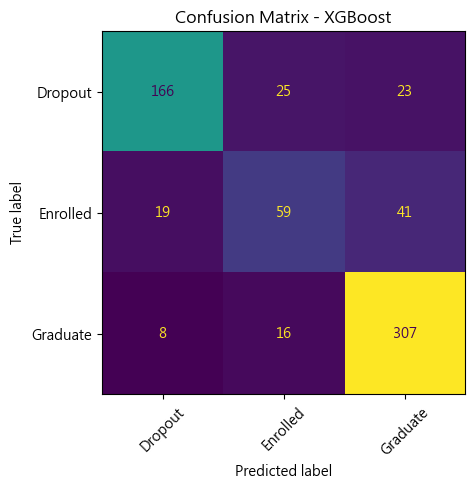


===== 測試集評估：MLP LeakyReLU (ES) =====
              precision    recall  f1-score   support

     Dropout       0.89      0.71      0.79       214
    Enrolled       0.46      0.69      0.55       119
    Graduate       0.87      0.83      0.85       331

    accuracy                           0.77       664
   macro avg       0.74      0.74      0.73       664
weighted avg       0.81      0.77      0.78       664

🎯 Accuracy = 0.7681
🧮 Weighted -> Precision = 0.8061 | Recall = 0.7681 | F1 = 0.7795
⚖️  Macro   -> Precision = 0.7428 | Recall = 0.7449 | F1 = 0.7328


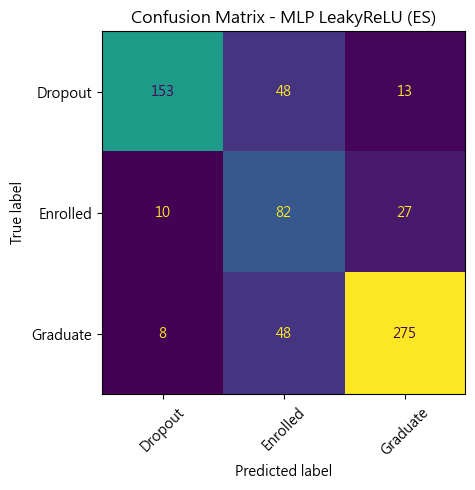


===== 測試集評估：MLP ReLU (ES) =====
              precision    recall  f1-score   support

     Dropout       0.88      0.67      0.76       214
    Enrolled       0.40      0.70      0.51       119
    Graduate       0.89      0.79      0.84       331

    accuracy                           0.73       664
   macro avg       0.72      0.72      0.70       664
weighted avg       0.80      0.73      0.75       664

🎯 Accuracy = 0.7334
🧮 Weighted -> Precision = 0.7985 | Recall = 0.7334 | F1 = 0.7525
⚖️  Macro   -> Precision = 0.7232 | Recall = 0.7181 | F1 = 0.7012


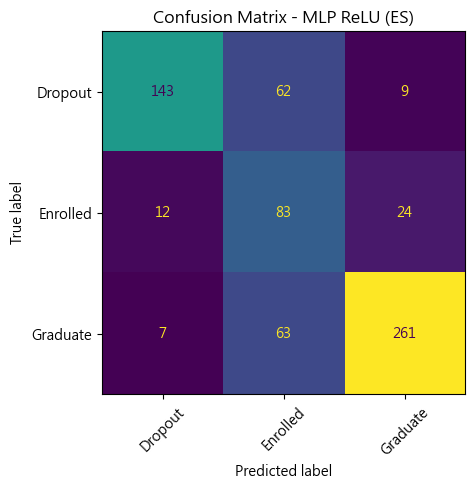


===== 測試集評估：MLP ReLU-5N (ES) =====
              precision    recall  f1-score   support

     Dropout       0.91      0.68      0.78       214
    Enrolled       0.45      0.67      0.54       119
    Graduate       0.86      0.85      0.86       331

    accuracy                           0.77       664
   macro avg       0.74      0.73      0.73       664
weighted avg       0.80      0.77      0.78       664

🎯 Accuracy = 0.7651
🧮 Weighted -> Precision = 0.8042 | Recall = 0.7651 | F1 = 0.7753
⚖️  Macro   -> Precision = 0.7422 | Recall = 0.7349 | F1 = 0.7258


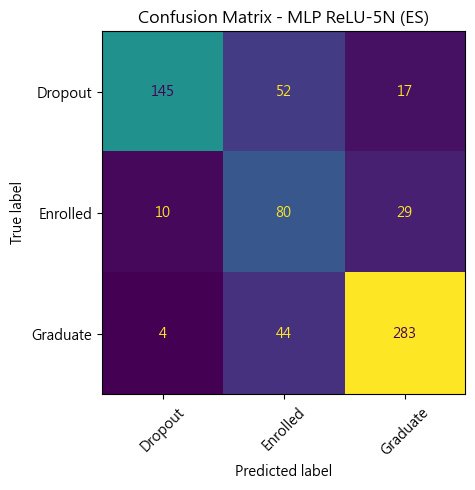

In [1329]:
import re
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

def _safe_name(name: str) -> str:
    return re.sub(r'[^A-Za-z0-9_.-]+', '_', name)

def evaluate_on_test(
    model,
    name="model",
    is_torch=True,
    device=None,
    test_dl=None,
    X_test_np=None,
    y_test=None,
    class_names=None,
    save_fig=True,
    fig_dir="outputs",
    show_norm_cm=False
):
    """
    統一測試評估：
      - is_torch=True  -> 需要 (device, test_dl)
      - is_torch=False -> 需要 (X_test_np, y_test)
    會輸出分類報告、四大指標、混淆矩陣（原始/比例），並回傳指標與 y_true/y_pred/cm。
    """
    assert class_names is not None, "請傳入 class_names（list[str]）"
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    safe = _safe_name(name)

    # ---- 取得 y_true / y_pred ----
    if is_torch:
        assert (device is not None) and (test_dl is not None), "is_torch=True 需提供 device 與 test_dl"
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = logits.argmax(1)
                y_pred.extend(preds.detach().cpu().numpy().tolist())
                y_true.extend(yb.detach().cpu().numpy().tolist())
    else:
        assert (X_test_np is not None) and (y_test is not None), "is_torch=False 需提供 X_test_np 與 y_test"
        y_true = y_test
        y_pred = model.predict(X_test_np)

    # ---- 指標 ----
    acc  = accuracy_score(y_true, y_pred)
    prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_w  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1_w   = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    # 可選：同時回報 macro
    prec_m = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_m  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_m   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\n===== 測試集評估：{name} =====")
    print(classification_report(y_true, y_pred, target_names=[str(c) for c in class_names]))
    print(f"🎯 Accuracy = {acc:.4f}")
    print(f"🧮 Weighted -> Precision = {prec_w:.4f} | Recall = {rec_w:.4f} | F1 = {f1_w:.4f}")
    print(f"⚖️  Macro   -> Precision = {prec_m:.4f} | Recall = {rec_m:.4f} | F1 = {f1_m:.4f}")

    # ---- 混淆矩陣（原始）----
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay(cm, display_labels=[str(c) for c in class_names]).plot(
        ax=ax, xticks_rotation=45, colorbar=False
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    if save_fig:
        plt.savefig(Path(fig_dir) / f"cm_{safe}.png", dpi=200)
    plt.show()

    # ---- 混淆矩陣（比例化）----
    if show_norm_cm:
        cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))), normalize='true')
        fig, ax = plt.subplots(figsize=(6, 5))
        ConfusionMatrixDisplay(cm_norm, display_labels=[str(c) for c in class_names]).plot(
            ax=ax, xticks_rotation=45, colorbar=True
        )
        plt.title(f"Normalized Confusion Matrix - {name}")
        plt.tight_layout()
        if save_fig:
            plt.savefig(Path(fig_dir) / f"cm_norm_{safe}.png", dpi=200)
        plt.show()
    else:
        cm_norm = None

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision_w": prec_w,
        "Recall_w": rec_w,
        "F1_w": f1_w,
        "Precision_m": prec_m,
        "Recall_m": rec_m,
        "F1_m": f1_m,
        "y_true": np.array(y_true),
        "y_pred": np.array(y_pred),
        "cm": cm,
        "cm_norm": cm_norm
    }
# XGBoost
metrics_xgb = evaluate_on_test(
    xgb, name="XGBoost", is_torch=False,
    X_test_np=X_test_np, y_test=y_test, class_names=class_names
)
# LeakyReLU (ES)
metrics_sig = evaluate_on_test(
    model_sig_es, name="MLP LeakyReLU (ES)", is_torch=True,
    device=device, test_dl=test_dl, class_names=class_names
)
# ReLU (ES)
metrics_relu = evaluate_on_test(
    model_relu_es, name="MLP ReLU (ES)", is_torch=True,
    device=device, test_dl=test_dl, class_names=class_names
)



# ReLU-5N (ES)
metrics_relu_5n = evaluate_on_test(
    model_relu_es_5n, name="MLP ReLU-5N (ES)", is_torch=True,
    device=device, test_dl=test_dl, class_names=class_names
)



In [1330]:
import pandas as pd

def to_row(m):
    return {
        "Model": m["Model"],
        "Accuracy": m["Accuracy"],
        "Precision(w)": m["Precision_w"],
        "Recall(w)": m["Recall_w"],
        "F1(w)": m["F1_w"],
        "Precision(m)": m["Precision_m"],
        "Recall(m)": m["Recall_m"],
        "F1(m)": m["F1_m"],
    }

results_df = pd.DataFrame([to_row(metrics_xgb),
                           to_row(metrics_sig),
                           to_row(metrics_relu),
                           to_row(metrics_relu_5n)])
print("\n📊 多模型評估指標比較：")
display(results_df)



📊 多模型評估指標比較：


,Model,Accuracy,Precision(w),Recall(w),F1(w),Precision(m),Recall(m),F1(m)
0,XGBoost,0.801205,0.795440,0.801205,0.795468,0.759199,0.732997,0.743060
1,MLP LeakyReLU (ES),0.768072,0.806118,0.768072,0.779533,0.742809,0.744948,0.732796
2,MLP ReLU (ES),0.733434,0.798545,0.733434,0.752466,0.723170,0.718074,0.701161
3,MLP ReLU-5N (ES),0.765060,0.804169,0.765060,0.775272,0.742226,0.734941,0.725810
